# MELTS geobarometry part 1 - quartz - 2-feldspar saturated rhyolites

- The position of the quartz - 2-feldspar eutectic in high-silca rhyolitic magmas is sensitive to pressure (and possibly other variables; fO$_2$, H$_2$O, CO$_2$).
- If MELTS accurately recreates phase stability (and the sensitivity to the relevant parameters), it could be used as a barometer in igneous systems by searching for the pressure at which the mineral saturation curves intersect.

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files (https://magmasource.caltech.edu/gitlist/MELTS_Matlab.git/) and store them locally on their computer. These files then need to be added to the Python path by using the $sys.path.append()$ command below.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

import pyMELTScalc as M
sys.path.append(r'MELTS')

M.__version__


'0.1.28'

In [3]:
# used to suppress MELTS outputs in MacOS systems (run twice)
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

To demonstrate how pyMELTScalc can be used to evaluate the pressure of magma storage we will use the composition of a quartz-hosted melt inclusion from Anderson et al. (2000) to evaluate the method:

In [4]:
bulk = {'SiO2_Liq': 77.6,
       'TiO2_Liq': 0.09,
       'Al2O3_Liq': 12.3,
       'FeOt_Liq': 0.65,
       'MgO_Liq': 0.02,
       'CaO_Liq': 0.41,
       'Na2O_Liq': 4.49,
       'K2O_Liq': 4.69}

In this case, we evaluate the saturation temperature of quartz, plagioclase, and k-feldspar at 32 pressures between 250 and 5000 bars. The model runs an equilibrium crystallisation calculation at each pressure (these calculations are run in parallel),with the calculations starting at the liquidus and continuing until either: (i) all three phases are saturated; or (ii) the temperature is more than 25$^o$C below the liquidus (T_maxdrop_C).

The function will then calculate the maximum temperature separating the saturation of the 3 phases and use a spline fit to determine the pressure of the minimum offset. This pressure is then taken forward as the pressure of storage/extraction.

In [5]:
P_bar = np.linspace(250, 5000, 32)
phases = ['quartz1', 'plagioclase1', 'k-feldspar1']
Results = M.find_mineral_cosaturation(bulk = bulk, 
                                   Model = "MELTSv1.0.2",
                                   phases = phases,
                                   P_bar = P_bar, 
                                   T_initial_C = 900,
                                   H2O_Sat = True,
                                   find_min = True,
                                   fO2_buffer = "NNO")

To evaluate these results we can do a few different things.

First, we can use a series of in-built plotting functions to visualise the results. For example, we can view the saturation surfaces of the three phases against pressure.

(<Figure size 500x400 with 1 Axes>,
 <Axes: xlabel='P (bars)', ylabel='T ($\\degree$C)'>)

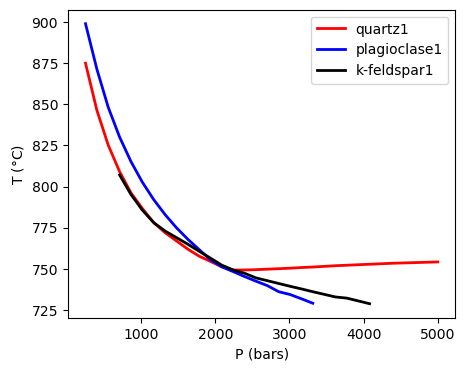

In [7]:
M.plot_surfaces(Results = Results, P_bar = P_bar, phases = phases)

Alternatively we can examine the residual temperatures and how these vary with pressure (along with the spline fit).

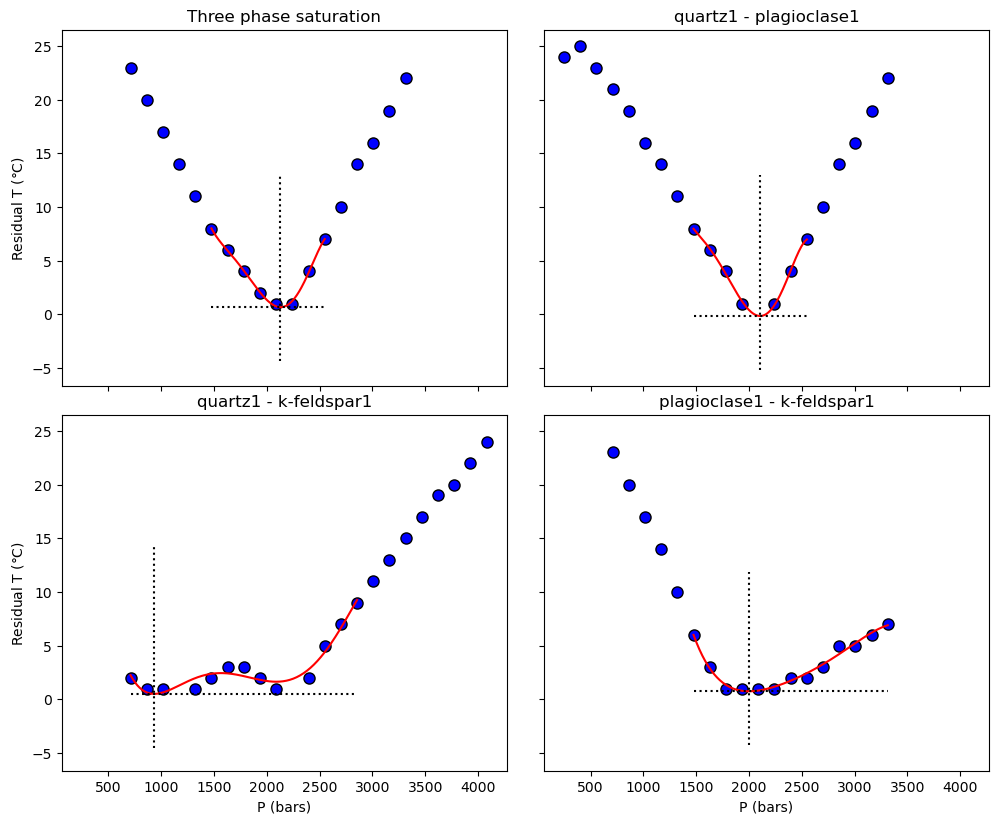

In [8]:
M.residualT_plot(Results = Results, P_bar = P_bar, phases = phases)

Alternatively, we can extract the pressure of magma storage directly from the 'Results' output variable. Doing so reveals that 'Results' contains a variety of information. First, it contains arrays for the saturation temperature of the three phases (at each pressure). Second, the liquidus temperature and the melt H$_2$O content at the liquidus is also included. Third, the temperature residuals between the saturation points of the different phases are also stored in this output. Finally, if 'find_min = True' has been selected in the initial function, the 'Results' variable will also contain the minimum pressure determined by the spline-fit to the data.

In [9]:
Results.keys()

dict_keys(['quartz1', 'plagioclase1', 'k-feldspar1', 'T_Liq', 'H2O_melt', '3 Phase Saturation', 'quartz1 - plagioclase1', 'quartz1 - k-feldspar1', 'plagioclase1 - k-feldspar1', 'CurveMin'])

Examine the quartz saturation temperature (pressure is given by the variable P_bar):

In [10]:
Results['quartz1']

array([[[875. , 846.4, 825.2, 809.1, 796.2, 786.7, 778.1, 772. , 767. ,
         762. , 757.7, 754.5, 751.2, 749.3, 749.3, 749.5, 749.8, 750.1,
         750.4, 750.8, 751.1, 751.5, 751.9, 752.2, 752.5, 752.8, 753.1,
         753.4, 753.6, 753.8, 754. , 754.2]]])

Examine the temperature residual between quartz and plagioclase saturation:

In [11]:
Results['quartz1 - plagioclase1']

array([[[24., 25., 23., 21., 19., 16., 14., 11.,  8.,  6.,  4.,  1.,
         nan,  1.,  4.,  7., 10., 14., 16., 19., 22., nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan]]])

In [9]:
print('Pressure of minimum residual: ' + str(round(Results['CurveMin']['3 Phase Saturation']['P_min'],2)) + ' bars')
print('Minimum temperature residual: ' + str(round(Results['CurveMin']['3 Phase Saturation']['Res_min'], 2)) + ' $^o$C')

Pressure of minimum residual: 2127.98 bars
Minimum temperature residual: 0.68 $^o$C


## How does parallel processing affect calculation speeds?

Here we run the same calculations but investigate how parallel processing might influence the speed of the calculations by running the calculation first with only 1 process in parallel, then increasing this number to 2, 4, and 8.

In [12]:
import time
import multiprocessing

P_bar = np.linspace(250, 5000, 32)
phases = ['quartz1', 'plagioclase1', 'k-feldspar1']

c = np.array([1,2,4,8,16,32])
t = np.zeros(len(c))
for i in range(len(c)):
    if c[i] > multiprocessing.cpu_count():
        t[i] = np.nan
    else:
        Start = time.time()
        Results = M.find_mineral_cosaturation(bulk = bulk, 
                                        cores = c[i],
                                        Model = "MELTSv1.0.2",
                                        phases = phases,
                                        P_bar = P_bar, 
                                        T_initial_C = 900,
                                        H2O_Sat = True,
                                        find_min = True,
                                        fO2_buffer = "NNO")
        t[i] = time.time() - Start

In [13]:
# load in time constraints for when this code was run on different machines
# lenovo P620
t_P620 = np.array([96.53, 50.55, 27.87, 19.29, 16.13, 14.13])

Text(0.5, 58.7222222222222, 'No. of Parallel Processes')

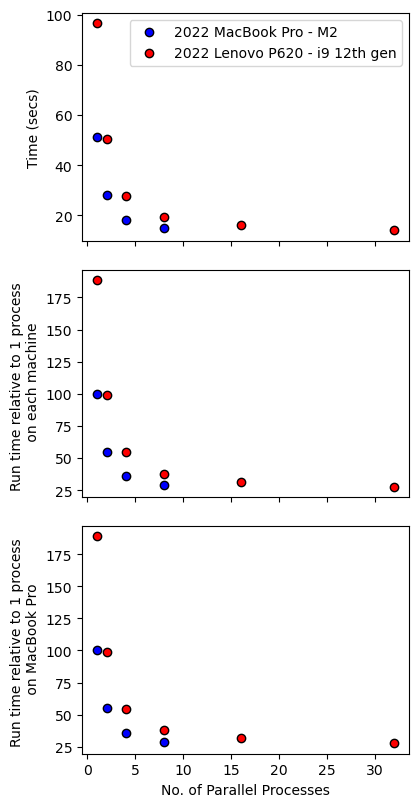

In [14]:
f, a = plt.subplots(3,1, figsize = (4, 8), sharex = True)
f.tight_layout()
a[0].plot(c, t, 'ob', mec = 'k', label = "2022 MacBook Pro - M2")
a[0].plot(c, t_P620, 'or', mec = 'k', label = "2022 Lenovo P620 - i9 12th gen")
a[0].set_ylabel('Time (secs)')
a[0].legend()

a[1].plot(c, 100*t/t[0], 'ob', mec = 'k', label = "2022 MacBook Pro - M2")
a[1].plot(c, 100*t_P620/t[0], 'or', mec = 'k', label = "2022 Lenovo P620 - i9 12th gen")
a[1].set_ylabel('Run time relative to 1 process \n on each machine')

a[2].plot(c, 100*t/t[0], 'ob', mec = 'k', label = "2022 MacBook Pro M2")
a[2].plot(c, 100*t_P620/t[0], 'or', mec = 'k', label = "2022 Lenovo P620 - i9 12th gen")
a[2].set_ylabel('Run time relative to 1 process \n on MacBook Pro')

a[2].set_xlabel('No. of Parallel Processes')